In [1]:
from datetime import datetime

from ipynb.fs.full.quantumsystem import qs, System, IntegerSystem, MetaSystem

In [2]:
class GameObject(System):
    """ Connects a game object to the gamestate """

class RoundCount(IntegerSystem):
    """ Records the number of rounds since the game began """

class GameEventTime(System):
    """ Which Team Is Active"""

class GameEventType(System):
    """ Which Team Is Active"""
    
class GameEventFaction(System):
    """ Which Team Is Active"""
    
class GameEventValue(System):
    """ Which Team Is Active"""
    
class GameEventResult(System):
    """ Which Team Is Active"""

@GameEventResult.sd
@GameEventValue.sd
@GameObject.sd
@GameEventFaction.sd
@GameEventType.sd
@RoundCount.sd
class GameEvent(MetaSystem):
    """ Game Event Record """

    @classmethod
    def meta_anchor(cls, anchor):
        return f"{cls.__name__}--{datetime.utcnow().isoformat()}"

    @classmethod
    @GameEventResult.decorator("gameEvent")
    def set_result(cls, gameEvent, newResult, gameeventresult):
        if gameeventresult != "null":
            raise Exception("Can only set null results")
        GameEventResult.set_relationship(gameEvent, newResult)

    @classmethod
    def get_events(cls, anchor):
        return [e['id'] for e in qs.v(anchor).out(cls.__name__).all()['result']]

    @classmethod
    def move_event(cls, gameEvent, oldAnchor, newAnchor):
        qs.drop(oldAnchor, cls.__name__, gameEvent)
        qs.put(newAnchor, cls.__name__, gameEvent)

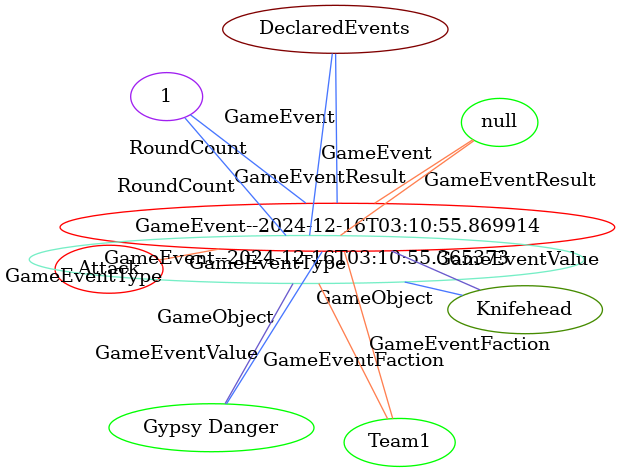

In [3]:
if __name__ == "__main__":
    from IPython.display import display

    qs.reset()
    GameEvent.build_system("DeclaredEvents", {
        "RoundCount": "1",
        "GameEventType": "Attack",
        "GameEventFaction": "Team1",
        "GameObject": "Knifehead",
        "GameEventValue": "Gypsy Danger",
        "GameEventResult": "null"})
    event = GameEvent.build_system("DeclaredEvents", {
        "RoundCount": "1",
        "GameEventType": "Attack",
        "GameEventFaction": "Team1",
        "GameObject": "Gypsy Danger",
        "GameEventValue": "Knifehead",
        "GameEventResult": "null"})
    display(qs.render())

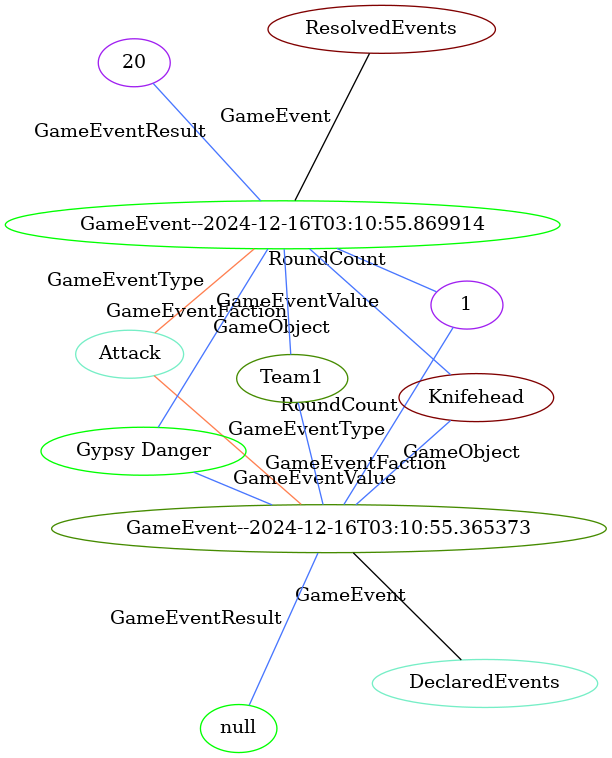

In [4]:
if __name__ == "__main__":
    GameEvent.set_result(gameEvent=event, newResult="20")
    GameEvent.move_event(gameEvent=event, oldAnchor="DeclaredEvents", newAnchor="ResolvedEvents")
    display(qs.render())